In [1]:
'''load trained models
'''

import pickle
import toothlib

cfg = toothlib.config
models = {}
edge_models = {}

for model_info in cfg['ML']['models'].values():
    with open(model_info['save_path'].replace('.pkl', '_depth.pkl'), 'rb') as mf:
        models[model_info['short_name']] = pickle.load(mf)
    with open(model_info['save_path'].replace('.pkl', '_edge.pkl'), 'rb') as mf:
        edge_models[model_info['short_name']] = pickle.load(mf)

dict_keys(['gbr', 'xgb'])


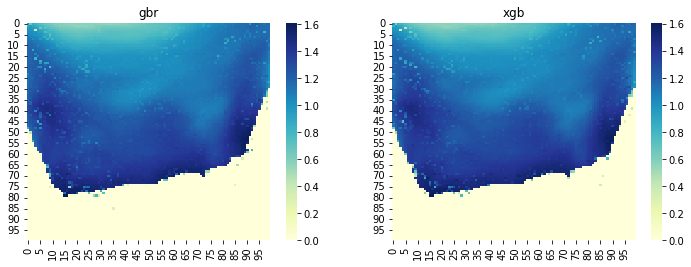

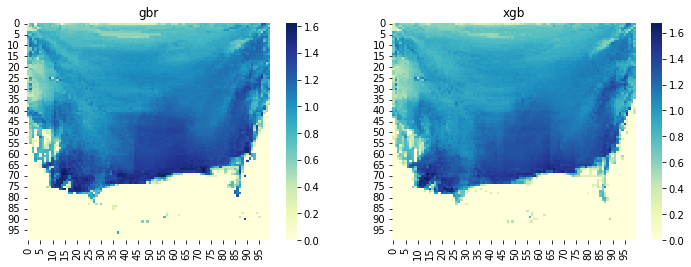

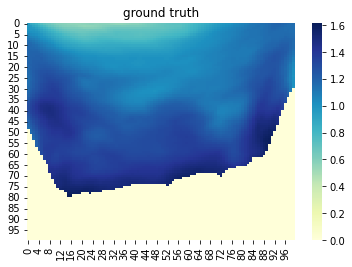

In [2]:
'''Predict tooth with CBCT and IOS
'''
import math
import numpy as np
import seaborn as sns
from matplotlib.pylab import plot
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel
from typing import Dict
import pandas as pd
import os

STYLE = 'YlGnBu'

feat_names = ['u', 'v', 'curv', 'metric_u', 'metric_v']

def draw_heatmap(mats: Dict[str, np.array], col_max: int, style: str = 'RdBu_r', savepath: str = None, vmax=None):
    grids = (math.ceil(len(mats) / col_max), col_max)
    sizes = (grids[1] * 6, grids[0] * 4)
    _, axes = plt.subplots(*grids, figsize=sizes)
    ind_r, ind_c = 0, 0
    for name, data in mats.items():
        # rotate 90 degree
        data = np.rot90(data, 2)
        if col_max == 1:
            if vmax:
                sns.heatmap(data, cmap=style, vmax=vmax)
            else:
                sns.heatmap(data, cmap=style)
            axes.set_title(name)
        else:
            if vmax:
                sns.heatmap(data, ax=axes[ind_r * grids[1] + ind_c], cmap=style, vmax=vmax)
            else:
                sns.heatmap(data, ax=axes[ind_r * grids[1] + ind_c], cmap=style)
            axes[ind_r * grids[1] + ind_c].set_title(name)
        ind_c = (ind_c + 1) % grids[1]
        if ind_c == 0:
            ind_r += 1
    if savepath:
        plt.savefig(savepath)
    else:
        plt.show()

def draw_lineplot(lines: Dict[str, np.array], col_max: int):
    grids = (math.ceil(len(lines) / col_max), col_max)
    sizes = (grids[1] * 6, grids[0] * 4)
    _, axes = plt.subplots(*grids, figsize=sizes)
    ind_r, ind_c = 0, 0
    for name, data in lines.items():
        if col_max == 1:
            sns.lineplot(data=data, ax=axes)
            axes.set_title(name)
        else:
            sns.lineplot(data=data, ax=axes[ind_r * grids[1] + ind_c])
            axes[ind_r * grids[1] + ind_c].set_title(name)
        ind_c = (ind_c + 1) % grids[1]
        if ind_c == 0:
            ind_r += 1
    plt.show()


def predict_with_model(th: toothlib.ToothComp, models: dict, edge_models: dict) -> dict:
    feats = th.get_features(feat_names, as_df=True)
    feats_ = feats.drop(columns=['u', 'metric_v'])
    feats_mean = feats_.apply(lambda x: x.values.reshape(th.meshes[0].topo_shape).mean(axis=0))
    preds = {}
    edge_preds = {}
    for name, model in models.items():
        preds[name] = model.predict(feats).reshape(th.meshes[0].topo_shape)
        preds[name] = np.where(preds[name] > 0.25, preds[name], 0.0)
    for name, model in edge_models.items():
        edge_preds[name] = model.predict(feats_mean)
    return preds, edge_preds

def save_result(tag: str, gt: np.ndarray, preds_CBCT: dict, preds_IOS: dict):
    pd.DataFrame({
        'Ground truth': gt.flatten(),
        'GBR CBCT': preds_CBCT['gbr'].flatten(),
        'GBR IOS': preds_IOS['gbr'].flatten(),
        'RF CBCT': preds_CBCT['rf'].flatten(),
        'RF IOS': preds_IOS['rf'].flatten()
    }).to_csv(f'./static/results/{tag}/raw.csv', index=False)

def predict_tooth(tag: str) -> tuple:
    if not os.path.exists(f'./static/results/{tag}'):
        os.mkdir(f'./static/results/{tag}')
    th_CBCT = toothlib.ToothComp('CBCT', tag)
    th_IOS = toothlib.ToothComp('IOS', tag)
    gt = th_CBCT.get_gt()
    preds_CBCT, edge_preds_CBCT = predict_with_model(th_CBCT, models, edge_models)
    preds_IOS, edge_preds_IOS = predict_with_model(th_IOS, models, edge_models)
    print(models.keys())
    # del preds_CBCT['bagging'], preds_IOS['bagging']
    # del edge_preds_CBCT['bagging'], edge_preds_IOS['bagging']
    draw_heatmap(preds_CBCT, 2, STYLE, f'./static/results/{tag}/CBCT.jpg')
    draw_heatmap(preds_IOS, 2, STYLE, f'./static/results/{tag}/IOS.jpg')
    draw_heatmap({'ground truth': gt}, 1, STYLE, f'./static/results/{tag}/GT.jpg')

    # draw_lineplot(edge_preds_CBCT, 3)
    # draw_lineplot(edge_preds_IOS, 3)
    # edge_gt = [gt[:, i].nonzero()[0][0] for i in range(gt.shape[1])]
    # draw_lineplot({'ground truth': edge_gt}, 1)
    # save_result(tag, gt, preds_CBCT, preds_IOS)

    # for name in models.keys():
    #     pred_CBCT = preds_CBCT[name].flatten()
    #     pred_IOS = preds_IOS[name].flatten()
    #     t, pval = ttest_rel(gt.flatten(), pred_CBCT)
    #     print(f'[{name}]', pval)
    #     t, pval = ttest_rel(gt.flatten(), pred_IOS)
    #     print(f'[{name}]', pval)
    #     t, pval = ttest_rel(pred_IOS, pred_CBCT)
    #     print(f'[{name}]', pval)

    # print(ttest_ind(preds_CBCT['gbr'].flatten(), preds_CBCT['bagging'].flatten(), equal_var=False))
    return th_CBCT, th_IOS, preds_CBCT, preds_IOS, gt

tag = 'N2'
# grid search
th_CBCT, th_IOS, preds_CBCT, preds_IOS, gt = predict_tooth(tag)

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

a = gt.flatten()
b = preds_IOS['gbr'].flatten()
print(f1_score(a, b))
# print('Accuracy(gbr):', accuracy_score(gt.flatten(), preds_IOS['gbr'].flatten()))
# print('Precision(gbr):', precision_score(gt.flatten(), preds_IOS['gbr'].flatten()))
# print('Recall(gbr):', recall_score(gt.flatten(), preds_IOS['gbr'].flatten()))
# print('F1(gbr):', f1_score(gt.flatten(), preds_IOS['gbr'].flatten()))
# print('AUC(gbr):', roc_auc_score(gt.flatten(), preds_IOS['gbr'].flatten()))

# print('Accuracy(rf):', accuracy_score(gt.flatten(), preds_IOS['rf'].flatten()))
# print('Precision(rf):', precision_score(gt.flatten(), preds_IOS['rf'].flatten()))
# print('Recall(rf):', recall_score(gt.flatten(), preds_IOS['rf'].flatten()))
# print('F1(rf):', f1_score(gt.flatten(), preds_IOS['rf'].flatten()))
# print('AUC(rf):', roc_auc_score(gt.flatten(), preds_IOS['rf'].flatten()))

ValueError: continuous is not supported

2.321740300529404 7.3017828578614e-06


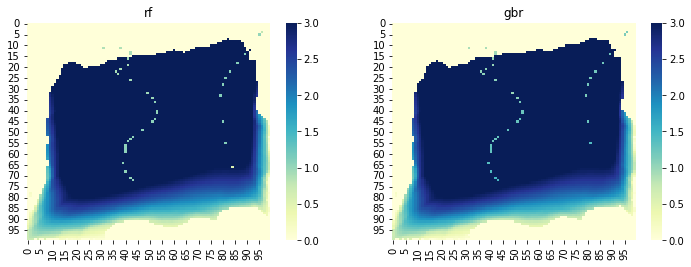

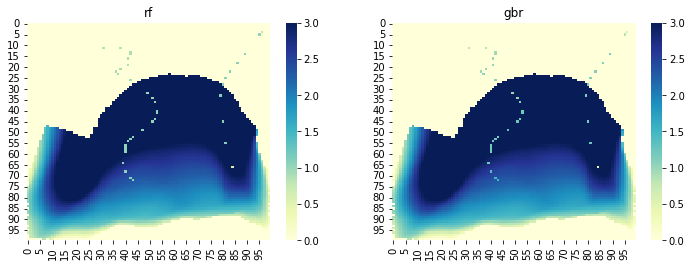

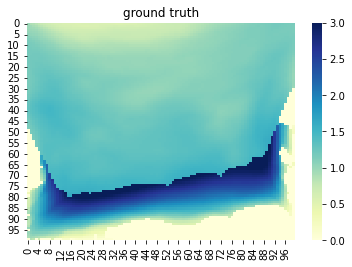

In [ ]:
import trimesh

def generate_p2(depth_map_p1_raw: np.array, mesh0: trimesh.Trimesh, mesh1: trimesh.Trimesh) -> np.array:
    depth_map_p1 = depth_map_p1_raw.reshape(100, 100)
    # find the non-zero boundary of depth_map_p1(shape 100, 100)
    zero_boundary_index = []
    for row in range(100):
        nonz = np.nonzero(depth_map_p1[row, :])[0]
        if len(nonz) == 0:
            continue
        _min, _max = min(nonz), max(nonz)
        if _min > 0: zero_boundary_index.append(row * 100 + _min)
        if _max < 99: zero_boundary_index.append(row * 100 + _max)
    
    index_p2 = np.argwhere(depth_map_p1_raw == 0.)
    avg_norm = np.sum(mesh0.vertex_normals[zero_boundary_index], axis=0)
    avg_norm /= np.linalg.norm(avg_norm)
    vts_p2 = mesh0.vertices[index_p2]
    # vts_p2 shape(n, 1, 3), reshape to (n, 3)
    vts_p2 = vts_p2.reshape(-1, 3)
    # print(zero_boundary_index)

    _dirs = -np.array([avg_norm] * len(vts_p2))
    # print(vts_p2[1])
    # exit(-1)
    loc, index_ray, _ = mesh1.ray.intersects_location(ray_origins=vts_p2, ray_directions=_dirs)
    _new_oris = vts_p2[index_ray]
    _dists = np.linalg.norm(_new_oris - loc, axis=1)
    ray_real_ind = np.array(range(10000))[index_p2][index_ray]
    depth_map_p1_raw[ray_real_ind] = _dists.reshape(-1, 1)
    return depth_map_p1_raw.reshape(100, 100)

def first_sequence_nonzero(data: np.array, start: int):
    for i in range(start, 100):
        if data[i] == data[i - 1] + 1:
            return i - 1
    return -1

def last_sequence_nonzero(data: np.array, start: int):
    for i in range(start, 100):
        if data[i] != data[i - 1] + 1:
            return i - 1
    return -1

def smooth_boundary(data: np.array):
    data_ = np.rot90(data.reshape(100, 100), 2)
    last_is = []
    for i in range(0, 100):
        nonz = np.nonzero(data_[:, i])[0]
        # nonz = nonz[nonz > last_v]
        idx = nonz[last_sequence_nonzero(nonz, 0)]
        last_is.append(idx)
    # make last_is smooth, no sudden change
    for i in range(1, 100):
        if last_is[i] - last_is[i - 1] > 3:
            last_is[i] = last_is[i - 1] + 3
    for i in range(1, 100):
        if last_is[i] - last_is[i - 1] < -3:
            last_is[i] = last_is[i - 1] - 3
    for i in range(0, 100):
        data_[last_is[i]:, i] = 0
    return np.rot90(data_, 2)

def transfer_boundary(rf_data: np.array, gbr_data: np.array) -> np.array:
    rf_data = np.rot90(rf_data.reshape(100, 100), 2)
    gbr_data = np.rot90(gbr_data.reshape(100, 100), 2)
    for i in range(100):
        nonz = np.nonzero(rf_data[:, i])[0]
        # gbr_data[:]
        gbr_data[nonz[-1]:, i] = 0
    
    return np.rot90(gbr_data, 2)

def show(
    th_CBCT: toothlib.ToothComp,
    th_IOS: toothlib.ToothComp,
    preds_CBCT: dict, preds_IOS: dict, gt):
    # for _, data in preds_CBCT.items():
        # data = smooth_boundary(data)
        # if _ == 'gbr':
            # data = transfer_boundary(preds_CBCT['rf'], data)
        # preds_CBCT[_] = data
    # for _, data in preds_IOS.items():
        # data = smooth_boundary(data)
        # if _ == 'gbr':
            # data = transfer_boundary(preds_IOS['rf'], data)
        # preds_IOS[_] = data

    for _, data in preds_CBCT.items():
        preds_CBCT[_] = generate_p2(data.flatten(), th_CBCT.meshes[0].m, th_CBCT.meshes[3].m)
    
    for _, data in preds_IOS.items():
        preds_IOS[_] = generate_p2(data.flatten(), th_IOS.meshes[0].m, th_IOS.meshes[1].m)

    gt = generate_p2(gt.flatten(), th_CBCT.meshes[0].m, th_CBCT.meshes[3].m)

    draw_heatmap(preds_CBCT, 2, STYLE, f'./static/results/{tag}/CBCT_comb.jpg', 3)
    draw_heatmap(preds_IOS, 2, STYLE, f'./static/results/{tag}/IOS_comb.jpg', 3)
    draw_heatmap({'ground truth': gt}, 1, STYLE, f'./static/results/{tag}/GT_comb.jpg', 3)
    return gt


tmsh = trimesh.load('mask.ply')
# the sdf
closest_pnts = np.abs(tmsh.nearest.signed_distance(th_IOS.meshes[0].m.vertices))
mask = np.where(closest_pnts > 1e-3)[0]

preds_IOS['gbr'] = preds_IOS['gbr'].flatten()
preds_IOS['gbr'][mask] = 0
preds_IOS['rf'] = preds_IOS['rf'].flatten()
preds_IOS['rf'][mask] = 0
preds_CBCT['gbr'] = preds_CBCT['gbr'].flatten()
preds_CBCT['gbr'][mask] = 0
preds_CBCT['rf'] = preds_CBCT['rf'].flatten()
preds_CBCT['rf'][mask] = 0
print(np.max(closest_pnts), np.min(closest_pnts))

def fix_hole(data) -> np.array:
    for i in range(1, 99):
        for j in range(1, 99):
            if data[i, j] == 0:
                if data[i - 1, j] > 0 and data[i + 1, j] > 0 and data[i, j - 1] > 0 and data[i, j + 1] > 0:
                    print('fix:', i, j)
                    data[i, j] = np.mean([data[i - 1, j], data[i + 1, j], data[i, j - 1], data[i, j + 1]])
    return data


preds_IOS['gbr'] = fix_hole(preds_IOS['gbr'].reshape(100, 100)).flatten()

gt = show(th_CBCT, th_IOS, preds_CBCT, preds_IOS, gt)

In [ ]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def make_heatmap(data: np.array, vmin: float, vmax: float, style: str='YlGnBu') -> np.array:
    norm = Normalize()
    cmap = cm.get_cmap(style)
    return cmap(norm(data)) * 255

def save_final(mesh: trimesh.Trimesh, data, name):
    data = data.flatten()
    mesh.visual.vertex_colors = make_heatmap(data, np.min(data), np.max(data))
    mesh.export(name)

def save_p3(mesh: trimesh.Trimesh, data, name):
    data = data.flatten()
    vt_colors = make_heatmap(data, np.min(data), np.max(data))
    ray_dirs = np.array([0, 1, 0] * len(mesh.vertices)).reshape(-1, 3) * data.reshape(-1, 1)
    ray_origins = mesh.vertices
    new_mesh = trimesh.Trimesh(vertices=ray_origins + ray_dirs, faces=mesh.faces)
    new_mesh.visual.vertex_colors = vt_colors
    new_mesh.export(name)

save_final(th_CBCT.meshes[0].m, preds_CBCT['gbr'], 'static/results/N5/ply/CBCT_gbr.ply')
save_final(th_CBCT.meshes[0].m, preds_CBCT['rf'], 'static/results/N5/ply/CBCT_rf.ply')
save_final(th_IOS.meshes[0].m, preds_IOS['gbr'], 'static/results/N5/ply/IOS_gbr.ply')
save_final(th_IOS.meshes[0].m, preds_IOS['rf'], 'static/results/N5/ply/IOS_rf.ply')
save_final(th_CBCT.meshes[0].m, gt, 'static/results/N5/ply/GT.ply')

save_p3(th_CBCT.meshes[0].m, preds_CBCT['gbr'], 'static/results/N5/ply/CBCT_gbr_p3.ply')
save_p3(th_CBCT.meshes[0].m, preds_CBCT['rf'], 'static/results/N5/ply/CBCT_rf_p3.ply')
save_p3(th_IOS.meshes[0].m, preds_IOS['gbr'], 'static/results/N5/ply/IOS_gbr_p3.ply')
save_p3(th_IOS.meshes[0].m, preds_IOS['rf'], 'static/results/N5/ply/IOS_rf_p3.ply')
save_p3(th_CBCT.meshes[0].m, gt, 'static/results/N5/ply/GT_p3.ply')

<ipython-input-4-eb8d1d9a5525>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(style)
